(Meas:measurements)=
# Measurements
Measurements, or the more formal word "observations", are in many ways our direct contact with the real world as they contribute with information on how our platform relates to the surroundings.

```{note}
Eventhough *measurements* and *observations* can be considerred as synomyms in this context, one may find it more natural to use the word *measurement* in this context.

Sensors measure - humans observe...
```

If we for example measure the distance from our trolley to a fixed point, we get information on the position. And if we count the revolutions of one of the wheels, we get information on the velocity.

![measure](fig/measure.jpg)

But it gets even more complicated than this as time goes by. If you measure position over time you will also indirectly get some information about the velocity. And the other way round, by measuring the velocity over time you will also indirectly get some information about the position. This is due to the fact that both position and velocity are naturally related to one another through the time derivative.

$$
\dot{x} = \frac{dx}{dt}
$$

In addition there may also likely be other connections beween the elements of the state vector in the dynamic model that also contribute with subtile connections within the system. We will get back to this later, but for now we continue with our trolley on rails.

## Measurement Equation
The measurement equation basically connects the measurements with one or more elements in the state vector. It can be stated as follows.

$$
z=Hx + v
$$

where the vector $z$ is the measurement vector, the matrix $H$ is called *design matrix*, the vector $x$ is the state vector and the vector $v$ is the measurement noise. Since we are directly measuring the position which is an element of the state vector, the measurement equation becomes as follows.

$$
\begin{bmatrix}
  z
\end{bmatrix}
=
\begin{bmatrix}
  1 &0\\
\end{bmatrix}
\begin{bmatrix}
  x\\
  \dot{x}\\
\end{bmatrix}
+
\begin{bmatrix}
  v
\end{bmatrix}
$$

Assume that we have a laser scanner on our trolley that measure the distance to a fixed point as in {ref}`Intro:mean_and_variance`. The laserscanner measures the distance every second as the trolley rolls ahead for 10 seconds.

```{figure} fig/laserscan.png
:name: laserscan_meas

Laser Scanner
```

### Simulating Measurements
When working with these initial examples, one problem is that we typically do not have any real measurements available to test the algorithms. So, in this situation it is sometimes useful to use the true process and generate a set of synthetic measurements with some specified measurement noise characteristics. This way we do not have to rely on any real measurements while prototyping, but we can instead simulate the performance of our algorithm with these syntetic measurements.

So, the generation of simulated distance measurements from a sensor sampling at 10Hz on our trolley rolling down the rails may look something like this.

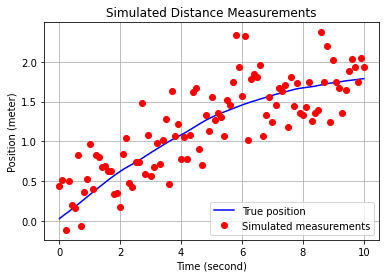

In [1]:
from numpy import array, sqrt, random, arange
import matplotlib.pyplot as plt

# System values
dt = 0.1       # interval [seconds] / (i.e. 10Hz)
samples = 100  # number of samples
qv = 0.01      # process noise [(meter/second)^2/second]
r = 0.1        # measurement noise [meter^2]

# Inital state vector
x0 = array([[0],      # position [meter]
            [0.3]])   # velocity [meter/second]
xt = x0

# Transition matrix
phi = array([[1, dt],
             [0, 1]])

# Design matrix
H = array([[1, 0]])

# Initialize plot vectors
xt_all = []; z_all = []

# Main loop
for k in range(0, samples + 1):
    
    # Compute true trajectory
    xt = phi@xt + array([[0],
                         [random.normal(0, qv)]])
    
    # Generate noisy measurements
    z = H@xt + random.normal(0, sqrt(r))
    
    # Accumulate plot vectors
    xt_all.append(xt)
    z_all.append(z)

# Extract plot information
pos_true = [xt[0, 0] for xt in xt_all]
z_sim = [z[0, 0] for z in z_all]

# Time
time = arange(0, samples + 1)*dt

# Plot results
plt.title('Simulated Distance Measurements')
plt.plot(time, pos_true, 'b', label='True position')
plt.plot(time, z_sim, 'ro', label='Simulated measurements')
plt.xlabel('Time (second)')
plt.ylabel('Position (meter)')
plt.legend(loc='lower right')
plt.grid();plt.show()

Note that real measurements are in general much more complex than these idealized simulated measurements as real measurements contain all sorts of sensor dependent effects such as: biases, scale factors and various sensor errors. In addition they are typically prone to outliers due to e.g. sensor malfunction that we need to adress before we can use them.

We will get back to real measurements later, so we stick to the simulated measurements for now.

### Example 3.1
What if the trolley contains a speedometer? Let's say that the sensor counts the number of wheel rotations as a function of time.

```{figure} fig/speed.png
Wheel Sensor
```

The first thing we need to to is to establish the connection between our velocity measurement and the elements of the state vector through the measurement equation.

$$
z = Hx + v
$$

Let's say we want to estimate velocity with this new sensor. A simple velocity sensor can be expressed as follows.

$$
v = \frac{2 \pi r}{\Delta t}
$$

where $v$ is the velocity, $r$ is the wheel radius and $\Delta t$ is the measured time interval between the pulses coming from the sensor. Thus the measurement equation can be written as follows.

$$
z = \frac{1}{2 \pi r}\dot{x}
$$

In matrix form it will look something like this.

$$
\begin{bmatrix}
  z\\
\end{bmatrix}
=
\begin{bmatrix}
  0 &\frac{1}{2 \pi r}\\
\end{bmatrix}
\begin{bmatrix}
  x\\
  \dot{x}\\
\end{bmatrix}
+
\begin{bmatrix}
  v\\
\end{bmatrix}
$$

Note that if we estimate the velocity this way, we will get all our measurements with varying frequency depending on the velocity. Thus we get more measurements when the velocity is high, and fewer measurements when the velocity is low. This behaviour doesn't fit well in a digital filter design, so in practice we will need to resample these measurements at constant intervals before they enter the filter. This resampling is typically done at the sensor side in order for the sensor to provide measurements at constant time intervals.

```{note}
Note that most digital sensors that we use for navigation will typically provide their measurements at constant time intervals.
```

Then how do we deal with measurements having different sampling rates and also out of synchronization? We get back to this later on. For now we assume that the measurements are provided by the sensor at constant time intervals.

(Meas:nonlinear)=
## Non-Linear Measurements
So, until now we have been looking at measurement equations that have a linear relationship between the measurements and the elements of the state vector, e.g. the distance and velocity measurements in the previous examples.

But what happens when the relationship is non-linear? One simple example of getting a non-linear relationship between the measurements and the elements of the state vector is by mounting our laser scanner a little bit higher, thus measuring the slope distance.

```{figure} fig/laserscan_nl.png
:name: laserscan_nl

Laser Scanner (high mount)
```

Again the first thing we need to do is to establish the connection between our measured slope distance and the elements of the state vector through the measurement equation.

$$
z = Hx + v
$$

The relationship between the measured slope distance and the elements of the state vector can easilly be derived from the figure. It will look something like this.

$$
z = f(x, h) = \sqrt{x^2 + h^2}
$$

where $z$ is the slope distance, $x$ is the position and $h$ is the mounting height. The mounting height is here assumed to be constant.

This is obviously a non-linear equation that doesn't fit our generic linear measurement equation. Therefore it must be linearized in order to be able to use our linear framwork. In practice the actual linearization is done through *Jacobian matrices* while introducing a set of preliminary values to represent geometry at every instant in time. The Jacobian matrix is a essentially a generalization of the gradient of a vector valued function of several variables.

### Preliminary values
In order to establish an approximation of the correct geometry, we need to introduce *preliminary values* to represent these quantities. In the following example we will need to introduce prelimary values for both the slope distance and the unknown position.

$$
\begin{align}
  s =& s_0 + ds\\
  x =& x_0 + dx\\
\end{align}
$$

First we will rename the slope distance from $z$ to $s$ to avoid confusion with our previous notation. Then we can approximate the slope distance as follows.

$$
s \approx s_0 + \frac{\partial f(x)}{\partial x} dx
$$

where $s$ is the slope distance and $s_0$ is the preliminary slope distance. Rearranging the equation slightly and introducing the preliminary values for the unknowns, we can now write like this.

$$
s - s_0 = \frac{x_0}{\sqrt{x_0^2 + h^2}} dx
$$

For completness, we also write the linear matrix form of the measurement equation. It becomes like this.

$$
z = Hx + v
$$

$$
\begin{bmatrix}
  s - s_0\\
\end{bmatrix}
=
\begin{bmatrix}
  \frac{x_0}{\sqrt{x_0^2 + h^2}}\\
\end{bmatrix}
\begin{bmatrix}
  dx\\
\end{bmatrix}
+
\begin{bmatrix}
  v\\
\end{bmatrix}
$$

```{note}
Note that that by the use of *sympy's* internal Jacobian function we can effectively derive the design matrix representing our linearized slope distance.
```

This is the same as the one we derived above as we expected.

In [2]:
from sympy import Matrix, symbols, sqrt

x0, h = symbols('x0 h')

# Measurement equation
s = Matrix([sqrt(x0**2 + h**2)])

# Vector of variables
y = Matrix([x0])

# Design matrix
H = s.jacobian(y)
display(H)

Matrix([[x0/sqrt(h**2 + x0**2)]])

From now on we will use this approach whenever we need to establish linearized versions of any non-linear equations. This goes both for the dynamic equations and for the measurement equations as they both may be non-linear by nature.

### Example 3.2
To verify the validity of our linearization, we introduce a numerical example based on a our measured slope distance with the laser scanner. Note that the number of significant digits in the results below are intentionally chosen to be somewhat large, i.e. five digits. However, the reason for this is to visualise the level of significant digits in which the iteration converges.

In [3]:
from numpy import array, sqrt
from numpy.linalg import inv

# Initial values
h = 1       # Mounting height [meter]
s = 3.47    # Measured slope distance [meter]
x0 = 2.0    # Preliminary position [meter]


# 1. Estimated position from slope distance (non-linear)
x = sqrt(s**2 - h**2)
print(f"Estimated position (non-linear): {x:10.5f} m")


# 2. Estimated position from slope distance (linearized)

# Preliminary slope distance
s0 = sqrt(x0**2 + h**2)

# Measurement vector
z = s - s0

# Design matrix
H = x0/sqrt(x0**2 + h**2)

# Compute position
dx = 1/H*z
x = x0 + dx
print(f"Estimated position (linearized): {x:10.5f} m")

Estimated position (non-linear):    3.32278 m
Estimated position (linearized):    3.37958 m


Note the slight change in the value from the 2nd decimal onwards. The reason for this difference is the acurracy of the preliminary value $x_0$. Depending on the problem at hand, it is usually easy to provide reasonably good preliminary values for the geometry represented by the design matrix. Since the original measurement equation is linearized, it can only represent the linear trend in the original equaition. Thus for the approximation to reflect the true geometry, the preliminary value must be close enough to the unknown true value for the linear appriximation to reflect the real changes. Thus in practice we will have to iterate the solution until it converges to the true value.

In [4]:
# Iterate to improve the preliminary value
for i in range(0, 3):
    
    # Preliminary slope distance
    s0 = sqrt(x0**2 + h**2)
    
    # Measurement vector
    z = array(s - s0)
    
    # Design matrix
    H = x0/sqrt(x0**2 + h**2)
    
    # Compute position
    dx = 1/H*z
    x0 = x0 + dx
    print(f"Iteration {i:d} : {x0:10.5f} m")

Iteration 0 :    3.37958 m
Iteration 1 :    3.32282 m
Iteration 2 :    3.32278 m


## Summary
In this chapter we have breifly looked into the functional relationship between the measurements and the elements of the state vector. We will get back to this later on, but for now it will serve as an introduction to the concepts of a linear measurement equation. Further we looked into how we could simulate a set of measurements based on a computed trajectory from a dynamic model.

At last we also touched the linearization of non-linear measurement equations and the introduction of preliminary values to establish a representative geometry for the problem at hand.

The linearization of non-linear equations can be generalized as follows.

$$
\begin{align}
  z =& f(x, y, \dots)\\
  z =& f(x_0 + dx, y_0 + dy, \dots)\\
  \vdots \\
  z \approx& f(x_0, y_0, \dots) + \frac{\partial f(x, y, \dots)}{\partial x}dx + \frac{\partial f(x, y, \dots)}{\partial y}dy + \dots\\
\end{align}
$$

So, now it's about time to put it all togehter - we are ready for our very first generic approach to the filtering problem through what is also known as the Bayes filter...